In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from pathlib import Path

# directory and file paths
data_dir = Path("../data/")
interim_data_dir = data_dir / "interim"
processed_data_dir = data_dir / "processed"

interim_mortgage_file = interim_data_dir / "CountyMortgagesPercent-30-89DaysLate-thru-2020-09.csv"

In [25]:
mortgage_delinq_df = pd.read_csv(interim_mortgage_file)
mortgage_delinq_df = pd.concat([mortgage_delinq_df.iloc[:,0:4],mortgage_delinq_df.iloc[:,-7:]],axis = 1)
mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
0,National,NaN,United States,-----,1.8,1.2,1.0,0.8,0.9,1.0,0.8
1,County,AL,Baldwin County,'01003',1.7,1.0,1.1,1.1,1.2,0.8,0.8
2,County,AL,Jefferson County,'01073',2.6,1.8,1.5,1.4,1.3,1.4,1.2
3,County,AL,Lee County,'01081',2.3,0.9,0.7,0.6,0.6,0.7,0.5
4,County,AL,Madison County,'01089',1.8,1.0,1.0,0.7,0.8,1.0,0.9


,RegionType,State,Name,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
0,National,NaN,United States,-----,1.8,1.2,1.0,0.8,0.9,1.0,0.8
1,County,AL,Baldwin County,'01003',1.7,1.0,1.1,1.1,1.2,0.8,0.8
2,County,AL,Jefferson County,'01073',2.6,1.8,1.5,1.4,1.3,1.4,1.2
3,County,AL,Lee County,'01081',2.3,0.9,0.7,0.6,0.6,0.7,0.5
4,County,AL,Madison County,'01089',1.8,1.0,1.0,0.7,0.8,1.0,0.9


In [30]:
northeast = ["PA", "VT", "ME", "RI", "NY", "CT", "NH", "ME", "NJ"] 
midwest = ["OH", "IN", "IL", "MI", "WI", "MO", "IA", "MN", "KS", "NE", "SD", "ND"]
west = ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "CO", "NM"]
south = ["MD", "DE", "DC", "WV", "VA", "NC", "KY", "TN", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

conditions = [
    (mortgage_delinq_df['State'].isin(northeast)),
    (mortgage_delinq_df['State'].isin(midwest)),
    (mortgage_delinq_df['State'].isin(west)),
    (mortgage_delinq_df['State'].isin(south))
    ]

regions = ['Northeast', 'Midwest', 'West', 'South']

mortgage_delinq_df['Region'] = np.select(conditions, regions)

mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,Region
0,National,NaN,United States,-----,1.8,1.2,1.0,0.8,0.9,1.0,0.8,0
1,County,AL,Baldwin County,'01003',1.7,1.0,1.1,1.1,1.2,0.8,0.8,South
2,County,AL,Jefferson County,'01073',2.6,1.8,1.5,1.4,1.3,1.4,1.2,South
3,County,AL,Lee County,'01081',2.3,0.9,0.7,0.6,0.6,0.7,0.5,South
4,County,AL,Madison County,'01089',1.8,1.0,1.0,0.7,0.8,1.0,0.9,South


In [33]:
df_melted = mortgage_delinq_df.reset_index().melt(id_vars=['Name', "State", "FIPSCode", "Region"], 
                                                  value_vars=['2020-03',
                                                                                            '2020-04',
                                                                                            '2020-05',
                                                                                            '2020-06',
                                                                                            '2020-07',
                                                                                            '2020-08',
                                                                                            '2020-09'])
df_melted.head()

,Name,State,FIPSCode,Region,variable,value
0,United States,NaN,-----,0,2020-03,1.8
1,Baldwin County,AL,'01003',South,2020-03,1.7
2,Jefferson County,AL,'01073',South,2020-03,2.6
3,Lee County,AL,'01081',South,2020-03,2.3
4,Madison County,AL,'01089',South,2020-03,1.8


<AxesSubplot:xlabel='variable', ylabel='value'>

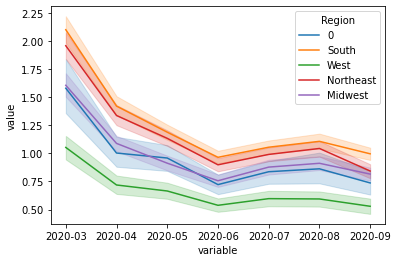

In [34]:
sns.lineplot(data=df_melted, x="variable", y="value", hue = "Region")

In [41]:
df_melted.loc[[0]]

,Name,State,FIPSCode,Region,variable,value
0,United States,NaN,-----,0,2020-03,1.8


In [44]:
df_states = df_melted.iloc[1:, :]
df_states.head()

,Name,State,FIPSCode,Region,variable,value
1,Baldwin County,AL,'01003',South,2020-03,1.7
2,Jefferson County,AL,'01073',South,2020-03,2.6
3,Lee County,AL,'01081',South,2020-03,2.3
4,Madison County,AL,'01089',South,2020-03,1.8
5,Mobile County,AL,'01097',South,2020-03,3.6


In [48]:
new_df = mortgage_delinq_df.groupby("State").mean()
new_df.head()

,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
State,,,,,,,
AK,1.700000,0.900000,1.100000,0.900000,1.000000,0.900000,0.700000
AL,2.487500,1.625000,1.375000,1.125000,1.187500,1.175000,1.075000
AR,1.675000,1.325000,1.100000,0.900000,1.000000,1.050000,0.950000
AZ,1.800000,1.233333,0.933333,0.783333,0.816667,0.883333,0.833333
CA,1.093548,0.751613,0.629032,0.493548,0.541935,0.545161,0.477419


<AxesSubplot:ylabel='State'>

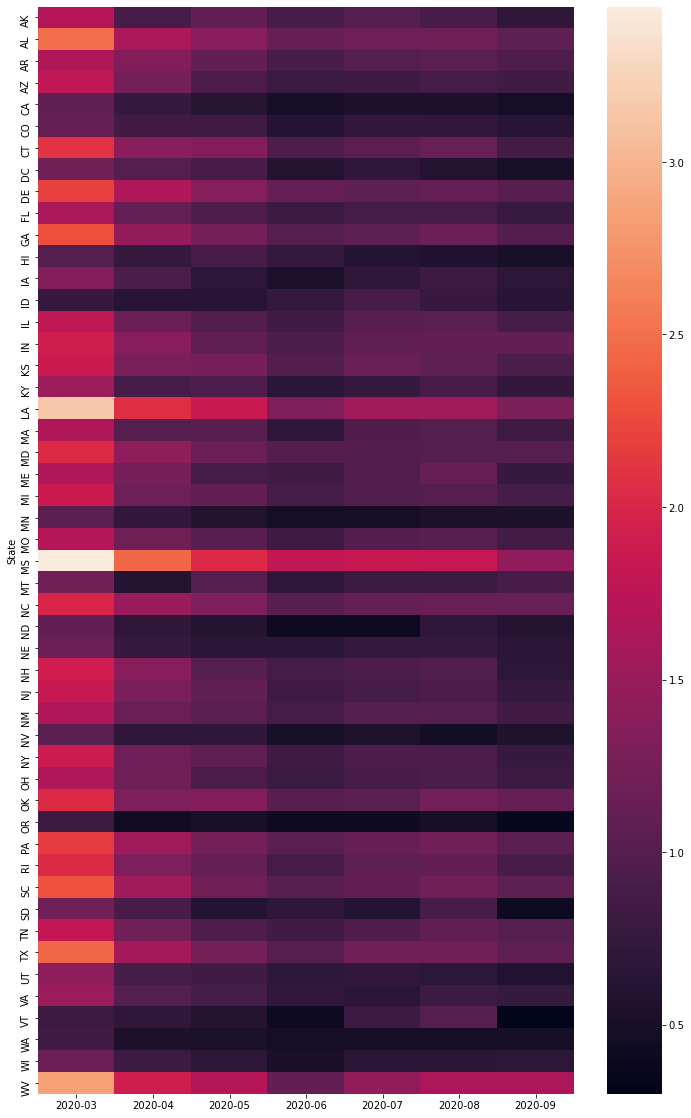

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,20))

sns.heatmap(new_df)

In [54]:
new_df = mortgage_delinq_df.groupby("Region").mean()
new_df.head()

,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
Region,,,,,,,
0,1.581481,1.003704,0.959259,0.722222,0.837037,0.862963,0.737037
Midwest,1.607547,1.089623,0.913208,0.756604,0.878302,0.912264,0.816038
Northeast,1.960494,1.338272,1.134568,0.898765,0.991358,1.044444,0.843210
South,2.103175,1.422222,1.189418,0.965608,1.055556,1.107937,0.996825
West,1.053623,0.718841,0.665217,0.537681,0.597101,0.594203,0.528986


<AxesSubplot:ylabel='Region'>

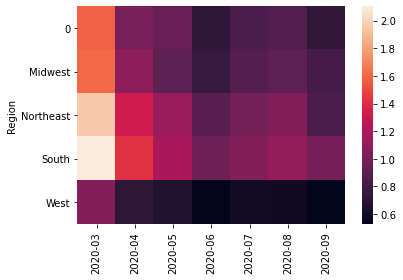

In [55]:
sns.heatmap(new_df)